In [2]:
import arviz as az
import pymc as pm
# import arviz.labels as azl

import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pickle
import matplotlib as mpl
import warnings
import numpy as np
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
from scipy.stats import norm
from scipy.optimize import minimize

## Reestimate model because of pickle problems

In [44]:
def gamma(alpha, beta):
    def g(x):
        return pm.Gamma(x, alpha=alpha, beta=beta)
    return g

def hcauchy(beta):
    def g(x):
        return pm.HalfCauchy(x, beta=beta)
    return g


def fit_gp(y, X, l_prior, eta_prior, sigma_prior, kernel_type='M52', bayes_kws=dict(draws=1000, tune=1000, chains=2, cores=1), prop_Xu=None):
    """
    function to return a pymc3 model
    y : dependent variable
    X : independent variables
    prop_Xu : number of inducing varibles to use. If None, use full marginal likelihood. If not none, use FTIC. 
    bayes_kw : kws for pm.sample
    X, y are dataframes. We'll use the column names. 
    """
    kernel_type = kernel_type.lower()
    with pm.Model() as model:
        # Covert arrays
        X_a = X.values
        y_a = y.values.flatten()
        X_cols = list(X.columns)

        
        # Kernels
        # 3 way interaction
        eta = eta_prior('eta')
        cov = eta**2
        for i in range(X_a.shape[1]):
            var_lab = 'l_'+X_cols[i]
            if kernel_type=='rbf':
                cov = cov*pm.gp.cov.ExpQuad(X_a.shape[1], ls=l_prior(var_lab), active_dims=[i])
            if kernel_type=='exponential':
                cov = cov*pm.gp.cov.Exponential(X_a.shape[1], ls=l_prior(var_lab), active_dims=[i])
            if kernel_type=='m52':
                cov = cov*pm.gp.cov.Matern52(X_a.shape[1], ls=l_prior(var_lab), active_dims=[i])
            if kernel_type=='m32':
                cov = cov*pm.gp.cov.Matern32(X_a.shape[1], ls=l_prior(var_lab), active_dims=[i])

        # Covariance model
        cov_tot = cov 
        
        # Noise model
        sigma_n =sigma_prior('sigma_n')

        # Model
        if not (prop_Xu is None):
            # Inducing variables
            num_Xu = int(X_a.shape[0]*prop_Xu)
            Xu = pm.gp.util.kmeans_inducing_points(num_Xu, X_a)
            gp = pm.gp.MarginalSparse(cov_func=cov_tot, approx="FITC")
            y_ = gp.marginal_likelihood('y_', X=X_a, y=y_a, Xu=Xu, noise=sigma_n)
        else:
            gp = pm.gp.Marginal(cov_func=cov_tot)
            y_ = gp.marginal_likelihood('y_', X=X_a, y=y_a, noise=sigma_n)
            
        
        if not (bayes_kws is None):
            trace = pm.sample(**bayes_kws)
            result = trace
        else:
            mp = pm.find_MAP(progressbar=False)
            result = mp
    
    return gp, result, model

def bootstrap(n_samples,y, X, seed=42, **kwargs):
    rng = np.random.default_rng(seed)
    all_params = []
    all_preds = []
    i = 0
    while i < n_samples:
        print(' ', i, end=', ')
        ix = np.array(y.index)
        bs_ix = rng.choice(ix, size=len(ix), replace=True)
        new_y, new_X = y.loc[bs_ix, :], X.loc[bs_ix, :]
        try: 
            gp, mp, model = fit_gp(new_y, new_X, **kwargs)
            all_params.append(mp)
            with model:
                y_pred, var = gp.predict(new_X.values, point=mp, diag=True)
                all_preds.append((new_y, y_pred, var))
            i += 1
            
        except: 
            print('error')

    print()

    return all_params, all_preds


def acquisition(x, gp, model, mp, mu_best): 
    x[0] = np.round(x[0], decimals=0)
    x = x.reshape(1, -1)

    y, var = gp.predict(x, pred_noise=True, diag=True, model=model, point=mp)
    
    sigma = np.sqrt(var)
    
    del_mu = (y-mu_best)
    
    z = del_mu/sigma
    
    ei = max(0, norm.cdf(z) + sigma*norm.pdf(z))
    return -1*ei


def exp_imp(y, var, mu_best): 
    sigma = np.sqrt(var)
    
    del_mu = (y-mu_best)
    
    z = del_mu/sigma
    
    ei = np.maximum(0, norm.cdf(z) + sigma*norm.pdf(z))
    return ei
        

In [4]:
root_path = '1fme/sensitivity'

l_prior = gamma(2, 0.5)
eta_prior = hcauchy(2)
sigma_prior = hcauchy(2)

feat, trans, kernel = 'distances', 'logistic', 'exponential'

results_path = Path(root_path).joinpath(f"{feat}_{trans}_{kernel}_mml.pkl")

results = pickle.load(results_path.open('rb'))
data_s = results['data']
y, X = data_s.iloc[:, [0]], data_s.iloc[:, 1:]

gp, mp, model = fit_gp(y, X, l_prior=l_prior, eta_prior=eta_prior, sigma_prior=sigma_prior, kernel_type=kernel, bayes_kws=None)

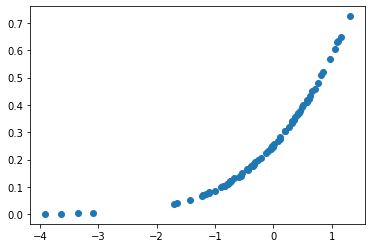

In [98]:
with model: 
    y_pred, var = gp.predict(X.values, point=mp, pred_noise=True, diag=True)
    
mu_best = np.max(y_pred)
sigma = np.sqrt(var)
del_mu = (y_pred-mu_best)
z = del_mu/sigma
ei = del_mu*norm.cdf(z) + sigma*norm.pdf(z)
plt.scatter(y_pred, ei)

In [94]:
xxs = [np.linspace(x, y, 5) for x, y in 
       zip(X.loc[ei > np.quantile(ei, 0.95), :].min(), 
           X.loc[ei > np.quantile(ei, 0.95), :].max())]
xxs[0] = xxs[0][[0, -1]]
xxs = np.meshgrid(*xxs)
xxs = [xx.reshape(-1, 1) for xx in xxs]
xgrid = np.concatenate(xxs, axis=1)

with model: 
    ygrid, vgrid = gp.predict(xgrid, point=mp, pred_noise=True, diag=True)
    
ei = exp_imp(ygrid, vgrid, mu_best)

In [105]:
hp_path = '../experiments/hpsample.h5'
min_s, max_s = -9, 2

hps = pd.read_hdf(hp_path)
hps.reset_index(inplace=True)

data = hps.loc[:, ['distances__scheme', 'tica__dim', 'tica__lag', 'cluster__k', 
            'distances__steepness', 'distances__centre']]

data['distances__scheme'] = data['distances__scheme'].apply(lambda x: 1*(x == 'closest-heavy'))
data = data.values

xmin, xmax = data.min(axis=0), data.max(axis=0)
                      
data_grid = (xgrid - min_s)*(xmax - xmin)/(max_s - min_s) + xmin

data_grid[:, 0] = xgrid[:, 0]

data_grid_sorted = data_grid[np.argsort(ei)[::-1], :]

In [104]:
new_hps = hps.copy(deep=True).iloc[[-1], :]
new_hps.hp_ix

,hp_ix,cluster__max_iter,cluster__stride,tica__dim,tica__lag,tica__kinetic_map,tica__stride,cluster__k,feature__value,dihedrals__which,distances__scheme,distances__transform,distances__steepness,distances__centre
139,328,1000,10,5,30,True,1,193,distances,NaN,ca,logistic,31.227324,0.263639


In [48]:
# x0 = X.loc[y_pred == mu_best, :].values

# bounds = [(0, 1), (-9, 2), (-9, 2), (-9, 2), (-9, 2), (-9, 2)]
# res = minimize(acquisition, x0, method='nelder-mead', options={'disp': True},  args=(gp, model, mp,  mu_best), bounds=bounds)